In [1]:
import numpy as np
import pandas as pd
import time
from numpy.polynomial import polynomial as poly
import matplotlib.pyplot as plt
# https://blog.openmined.org/build-an-homomorphic-encryption-scheme-from-scratch-with-python/

C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\433578642.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
### without using NTT
# def multiply(x, y, q, poly_q):
#     return np.int64(
#         np.round(poly.polydiv(poly.polymul(x, y) % q, poly_q)[1] % q)
#     )

# def add(x, y, q, poly_q):
#     return np.int64(
#         np.round(poly.polydiv(poly.polyadd(x, y) % q, poly_q)[1] % q)
#     )

def add(x, y, q, poly_q):
    # Make sure that x and y are the same length
    size = max(len(x), len(y))
    x = np.resize(x, size)  # Resize x to the size of the longest input
    y = np.resize(y, size)  # Resize y to the size of the longest input
    return (x + y) % q  # Perform the addition and modulus in one operation

def multiply(x, y, q, poly_q):
    # This is a placeholder for the multiplication using NTT
    # If poly_q is x^n + 1, we only need to take the lower part of the convolution
    result = np.convolve(x, y)[:-1] % q
    return result

    

In [3]:
def keygenerate(n, q, poly_q):
    s = np.random.randint(0, 2, (n))
    A = np.random.randint(0, q, (n))

    e = np.random.normal(0, 2, size=n)
   
    b = add(multiply(-A, s, q, poly_q), -e, q, poly_q)
    return (b, A), s

In [4]:
def encrypt(plaintext, publickey, q, poly_q, size, t):
    b, A = publickey

    # plaintext polynomial
    m = np.array([plaintext] + [0] * (size-1)) % t
    
    delta = q // t
    scaled_m = delta * m % q
    e1 = np.random.normal(0, 2, size=size)
    e2 = np.random.normal(0, 2, size=size)
    r = np.random.randint(0, 2, (size))
    
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))

    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
    return ct

In [5]:
def decrypt(ciphertext, privatekey, q, poly_q, t):
    a_prime, b_prime = ciphertext
    scaled_pt = add(
            multiply(b_prime, privatekey, q, poly_q),
            a_prime, q, poly_q
        )
    
    decrypted_poly = np.round(scaled_pt * t / q) % t

    return int(decrypted_poly[0])

## Example

In [6]:
q = 2**15
t = 2**8
n = 2**4

poly_q = np.array([1] + [0] * (n-1) + [1])

publickey, s = keygenerate(n, q, poly_q)

In [7]:
pt = 73
ct = encrypt(pt, publickey, q, poly_q, n, t)
ct

(array([ 9341., 32649.,  1355., 11115., 19191.,  6564., 24171., 10071.,
         8704.,  7288., 11268.,  7619., 28262., 22219.,  9227., 15797.,
        20607., 13969.,  5276., 30338., 27865., 29461., 17381., 28479.,
        14589.,  8975.,  1396., 24558.,  4974., 11457., 25302., 22098.,
        29806., 11484., 15403.,  9310.,  3098., 13129., 25050., 30562.,
        29414., 12921.,  5493., 14997.]),
 array([  116., 31412., 21542., 14930.,  4545., 27790., 29376., 14116.,
        24329., 12363.,  4214., 10786., 14660.,  1628., 10563.,  6736.,
        18091.,  4628., 10377., 20567.,  5331.,  4924., 13208., 30854.,
         8354.,  1281., 25336.,  9494., 17772., 19309.]))

In [8]:
pt2 = decrypt(ct, s, q, poly_q, t)
pt2

73

# Experiments on different schemes

In [9]:
def UniformMod(q, n):  
    a = -(q // 2)
    b = -a - 1 if q % 2 == 0 else -a
    samples = np.random.randint(a, b + 1, n)
    return samples

def CenteredBinomial(eta, n):
    a = np.random.binomial(eta, 0.5, n)
    b = np.random.binomial(eta, 0.5, n)
    return a-b

def SparseTernary(n, p, m=None):
    p = np.round(p).astype(int)
    if m is None:
        m = p

    vector = np.zeros(n, dtype=int)

    # Generate the indices for 1's and -1's without overlap
    ones_indices = np.random.choice(n, p, replace=False)
    remaining_indices = np.setdiff1d(np.arange(n), ones_indices)
    minus_ones_indices = np.random.choice(remaining_indices, m, replace=False)

    # Set the 1's and -1's in the vector
    vector[ones_indices] = 1
    vector[minus_ones_indices] = -1

    return vector

def cal_size(ct, q):
    a, b = ct
    # number of elements of the array in a prime and b prime
    elements_num = len(a) + len(b)
    # calculate number of bits needed for each element (with a range of 0 to q-1)
    size = elements_num * np.ceil(np.log2(q))
    # convert to bytes
    size /= 8
    return size

In [10]:
encryption_time = []
ct_size = []
#schemes = ["TFHE1024", "Concrete_TFHE512", "NewHope512", "NewHope1024", "Frodo640", "Frodo976", "Frodo1344"]
schemes = ["NewHope512", "NewHope1024", "Frodo640", "Frodo976", "Frodo1344"]
# shortest estimated time to break the schemes in the power of two
#security = [123.9, 64.4, 101, 233, 163.0, 225.2, 287.9]
security = [101, 233, 163.0, 225.2, 287.9]

# plaintext to encrypt on is an integer of 10bits
pt = 2**10
# we define plaintext modulus as two bits higher without the loss of generality
t = 2**12
pt

1024

### TFHE 1024

In [11]:
# # configurations
# n=1024
# q=2**32
# Xs=UniformMod(2, n)
# Xe=np.round(np.random.normal(0, 2 ** (-25) * 2**32, n)).astype(int)

# poly_q = np.array([1] + [0] * (n-1) + [1])
# A = np.random.randint(0, q, (n), dtype=np.int64)
# b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

In [12]:
# start = time.time()
# # encrypt 10 times and returns the average
# for i in range(10):
#     ct = encrypt(pt, (b, A), q, poly_q, n, t)
# time_needed = (time.time() - start) / 10
# print(time_needed)
# encryption_time.append(time_needed)
# size = cal_size(ct, q)
# print(size)
# ct_size.append(size)

In [13]:
# output = decrypt(ct, Xs, q, poly_q, t)
# assert pt == output

### Concrete TFHE 512

In [14]:
# n=512
# q=2**32
# Xs=UniformMod(2, n)
# Xe=np.round(np.random.normal(0, 2 ** (-24.8) * 2**32, n)).astype(int)

# poly_q = np.array([1] + [0] * (n-1) + [1])
# A = np.random.randint(0, q, (n), dtype=np.int64)
# b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

In [15]:
# start = time.time()
# for i in range(10):
#     ct = encrypt(pt, (b, A), q, poly_q, n, t)
# time_needed = (time.time() - start) / 10
# print(time_needed)
# encryption_time.append(time_needed)
# size = cal_size(ct, q)
# print(size)
# ct_size.append(size)

In [16]:
# output = decrypt(ct, Xs, q, poly_q, t)
# assert pt == output

### NewHope 512

In [17]:
n=512
q=12289
Xs=CenteredBinomial(8, n)
Xe=CenteredBinomial(8, n)

poly_q = np.array([1] + [0] * (n-1) + [1])
A = np.random.randint(0, q, (n), dtype=np.int64)
b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

In [18]:
start = time.time()
for i in range(10):
    m = np.array([pt] + [0] * (n-1)) % t
    delta = q // t
    scaled_m = delta * m % q
    e1 = CenteredBinomial(8, n)
    e2 = CenteredBinomial(8, n)
    r = np.random.randint(0, 2, (n))
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))
    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.0031034469604492186
4469.5


In [19]:
output = decrypt(ct, Xs, q, poly_q, t)
output
#assert pt == output

1023

### NewHope 1024

In [20]:
n=1024
q=12289
Xs=CenteredBinomial(8, n)
Xe=CenteredBinomial(8, n)

poly_q = np.array([1] + [0] * (n-1) + [1])
A = np.random.randint(0, q, (n), dtype=np.int64)
b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

In [21]:
start = time.time()
for i in range(10):
    m = np.array([pt] + [0] * (n-1)) % t
    delta = q // t
    scaled_m = delta * m % q
    e1 = CenteredBinomial(8, n)
    e2 = CenteredBinomial(8, n)
    r = np.random.randint(0, 2, (n))
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))
    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

0.005674123764038086
8949.5


In [22]:
output = decrypt(ct, Xs, q, poly_q, t)
#assert pt == output

### Frodo 640

In [23]:
n=640
q=2**15
Xs=np.round(np.random.normal(0, 2.8, n)).astype(int)
Xe=np.round(np.random.normal(0, 2.8, n)).astype(int)

poly_q = np.array([1] + [0] * (n-1) + [1])
A = np.random.randint(0, q, (n), dtype=np.int64)
b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

start = time.time()
for i in range(10):
    m = np.array([pt] + [0] * (n-1)) % t
    delta = q // t
    scaled_m = delta * m % q
    e1 = np.round(np.random.normal(0, 2.8, n)).astype(int)
    e2 = np.round(np.random.normal(0, 2.8, n)).astype(int)
    r = np.random.randint(0, 2, (n))
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))
    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

output = decrypt(ct, Xs, q, poly_q, t)
output
#assert pt == output

0.0032579183578491213
5988.75


1024

### Frodo 976

In [24]:
n=976
q=2**16
Xs=np.round(np.random.normal(0, 2.3, n)).astype(int)
Xe=np.round(np.random.normal(0, 2.3, n)).astype(int)

poly_q = np.array([1] + [0] * (n-1) + [1])
A = np.random.randint(0, q, (n), dtype=np.int64)
b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

start = time.time()
for i in range(10):
    m = np.array([pt] + [0] * (n-1)) % t
    delta = q // t
    scaled_m = delta * m % q
    e1 = np.round(np.random.normal(0, 2.3, n)).astype(int)
    e2 = np.round(np.random.normal(0, 2.3, n)).astype(int)
    r = np.random.randint(0, 2, (n))
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))
    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

output = decrypt(ct, Xs, q, poly_q, t)
output
#assert pt == output

0.004895138740539551
9748.0


1024

### Frodo 1344

In [25]:
n=1344
q=2**16
Xs=np.round(np.random.normal(0, 1.4, n)).astype(int)
Xe=np.round(np.random.normal(0, 1.4, n)).astype(int)

poly_q = np.array([1] + [0] * (n-1) + [1])
A = np.random.randint(0, q, (n), dtype=np.int64)
b = add(multiply(-A, Xs, q, poly_q), -Xe, q, poly_q)

start = time.time()
for i in range(10):
    m = np.array([pt] + [0] * (n-1)) % t
    delta = q // t
    scaled_m = delta * m % q
    e1 = np.round(np.random.normal(0, 1.4, n)).astype(int)
    e2 = np.round(np.random.normal(0, 1.4, n)).astype(int)
    r = np.random.randint(0, 2, (n))
    a_prime = np.round(add(
                add(
                    multiply(b, r, q, poly_q),
                    e1, q, poly_q),
                scaled_m, q, poly_q
            ))
    b_prime = np.round(add(
                multiply(A, r, q, poly_q),
                e2, q, poly_q
            ))
    ct = (a_prime, b_prime)
time_needed = (time.time() - start) / 10
print(time_needed)
encryption_time.append(time_needed)
size = cal_size(ct, q)
print(size)
ct_size.append(size)

output = decrypt(ct, Xs, q, poly_q, t)
output
#assert pt == output

0.009294080734252929
13428.0


1024

## Outputting the results

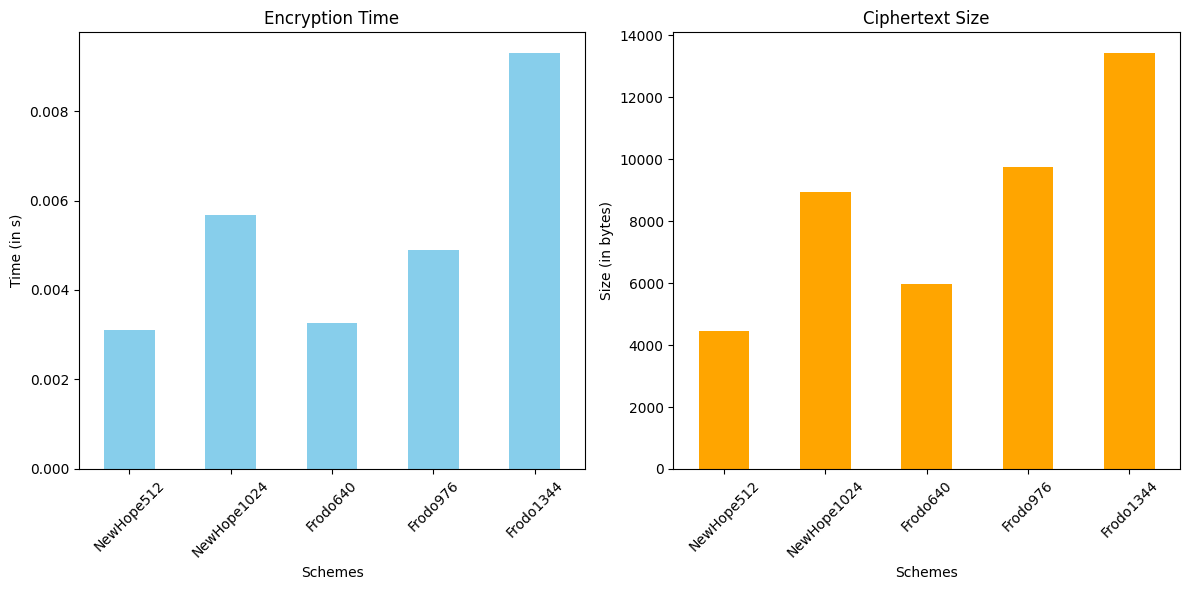

In [26]:
df = pd.DataFrame({
    'Time(in s)': encryption_time,
    'Size(in bytes)': ct_size,
    'Security(in bits)': security
}, index=schemes)

# Plotting graph
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot time data
df['Time(in s)'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Encryption Time')
axes[0].set_ylabel('Time (in s)')
axes[0].set_xlabel('Schemes')
axes[0].tick_params(axis='x', rotation=45)

# Plot size data
df['Size(in bytes)'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Ciphertext Size')
axes[1].set_ylabel('Size (in bytes)')
axes[1].set_xlabel('Schemes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\2717431325.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]))
C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\2717431325.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].annotate(txt, (df['Security(in bits)'][i], df['Size(in bytes)'][i]))


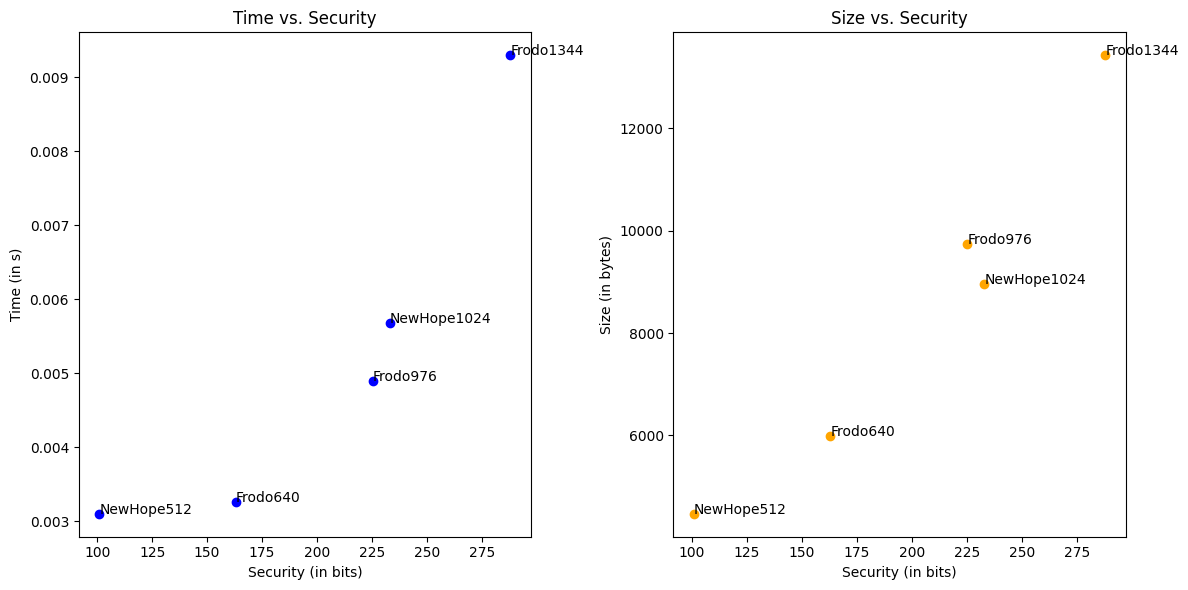

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 'Time(in s)' vs. 'Security(in bits)'
axes[0].scatter(df['Security(in bits)'], df['Time(in s)'], color='blue')
axes[0].set_title('Time vs. Security')
axes[0].set_xlabel('Security (in bits)')
axes[0].set_ylabel('Time (in s)')

for i, txt in enumerate(schemes):
    axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]))

# Plot 'Size(in bytes)' vs. 'Security(in bits)'
axes[1].scatter(df['Security(in bits)'], df['Size(in bytes)'], color='orange')
axes[1].set_title('Size vs. Security')
axes[1].set_xlabel('Security (in bits)')
axes[1].set_ylabel('Size (in bytes)')

for i, txt in enumerate(schemes):
    axes[1].annotate(txt, (df['Security(in bits)'][i], df['Size(in bytes)'][i]))


plt.tight_layout()
plt.show()


## Ring-LWE vs LWE

C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\3228046299.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]),
C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\3228046299.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]))
C:\Users\Haygen Tsoi\AppData\Local\Temp\ipykernel_19392\3228046299.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

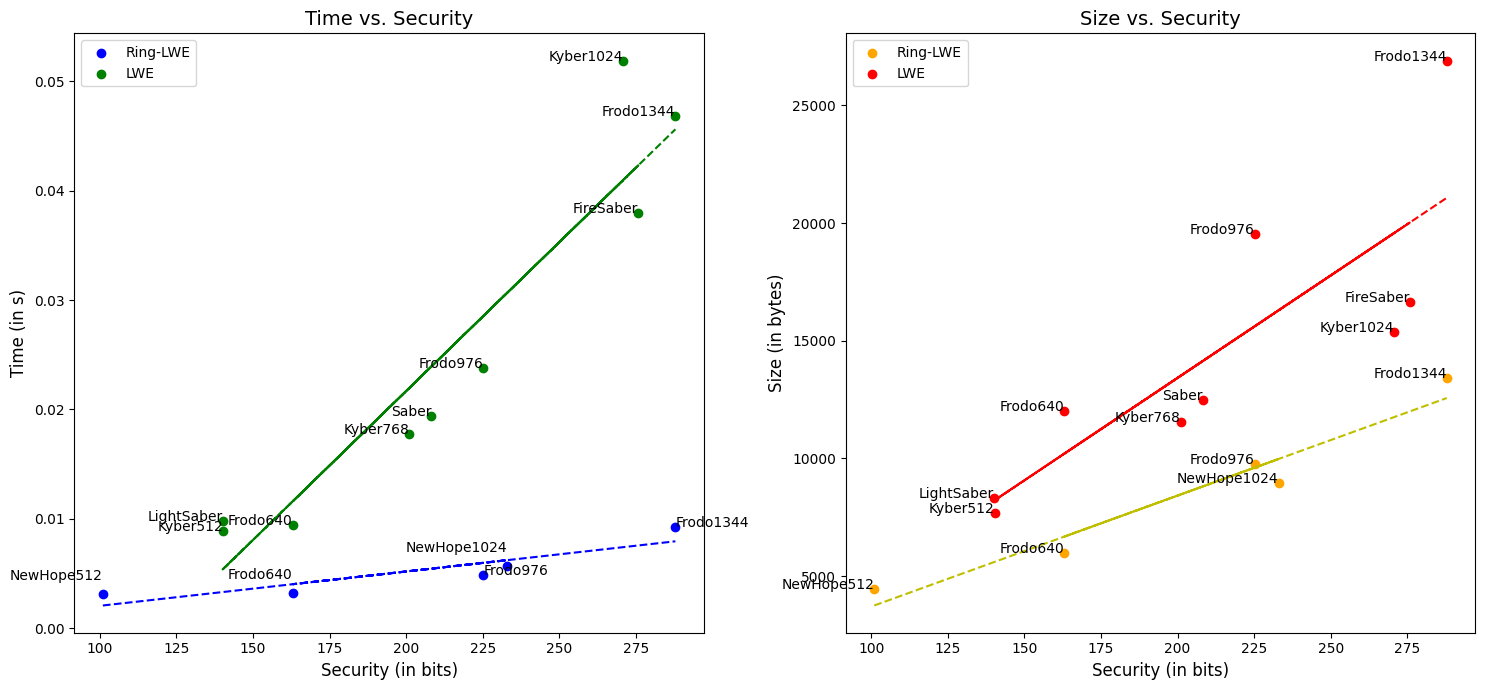

In [28]:
df2 = pd.DataFrame({
    'Time(in s)': [0.008863687515258789, 0.017716431617736818, 0.05190322399139404, 0.009805536270141602, 0.019374680519104005, 0.03796250820159912, 0.009429359436035156, 0.023816132545471193, 0.0468388557434082],
    'Size(in bytes)': [7695.0, 11535.0, 15375.0, 8336.25, 12496.25, 16656.25, 12018.75, 19540.0, 26900.0],
    'Security(in bits)': [140.3, 201.0, 270.8, 140.1, 208.2, 275.8, 163.0, 225.2, 287.9]
}, index=["Kyber512", "Kyber768", "Kyber1024", "LightSaber", "Saber", "FireSaber", "Frodo640", "Frodo976", "Frodo1344"])

# Recalculating the trend lines as the previous polynomials (p and p2) are not defined in this session.

# Generate the trend lines based on the provided data points.
z = np.polyfit(df['Security(in bits)'], df['Time(in s)'], 1)
p = np.poly1d(z)
z2 = np.polyfit(df2['Security(in bits)'], df2['Time(in s)'], 1)
p2 = np.poly1d(z2)

text_options = {'fontsize': 10, 'ha':'right'}

# Re-plotting the graph with adjusted annotations to avoid overlap.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Scatter plots
axes[0].scatter(df['Security(in bits)'], df['Time(in s)'], color='blue', label='Ring-LWE')
axes[0].scatter(df2['Security(in bits)'], df2['Time(in s)'], color='green', label='LWE')
axes[1].scatter(df['Security(in bits)'], df['Size(in bytes)'], color='orange', label='Ring-LWE')
axes[1].scatter(df2['Security(in bits)'], df2['Size(in bytes)'], color='red', label='LWE')

# Trend lines
axes[0].plot(df['Security(in bits)'], p(df['Security(in bits)']), "b--")
axes[0].plot(df2['Security(in bits)'], p2(df2['Security(in bits)']), "g--")
z3 = np.polyfit(df['Security(in bits)'], df['Size(in bytes)'], 1)
p3 = np.poly1d(z3)
axes[1].plot(df['Security(in bits)'], p3(df['Security(in bits)']), "y--")
z4 = np.polyfit(df2['Security(in bits)'], df2['Size(in bytes)'], 1)
p4 = np.poly1d(z4)
axes[1].plot(df2['Security(in bits)'], p4(df2['Security(in bits)']), "r--")

# Annotations to avoid overlap, with a small offset for the specified labels.
for i, txt in enumerate(df.index):
    if "NewHope" in txt or "Frodo640" in txt:
        axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]), 
                         textcoords="offset points", xytext=(0,10), **text_options)
    else:
        axes[0].annotate(txt, (df['Security(in bits)'][i], df['Time(in s)'][i]))
for i, txt in enumerate(df2.index):
    axes[0].annotate(txt, (df2['Security(in bits)'][i], df2['Time(in s)'][i]), **text_options)

# Repeating annotation process for the right graph.
for i, txt in enumerate(df.index):
    axes[1].annotate(txt, (df['Security(in bits)'][i], df['Size(in bytes)'][i]), **text_options)
for i, txt in enumerate(df2.index):
    axes[1].annotate(txt, (df2['Security(in bits)'][i], df2['Size(in bytes)'][i]), **text_options)

# Titles, labels, and legends.
axes[0].set_title('Time vs. Security', fontsize=14)
axes[0].set_xlabel('Security (in bits)', fontsize=12)
axes[0].set_ylabel('Time (in s)', fontsize=12)
axes[0].legend()
axes[1].set_title('Size vs. Security', fontsize=14)
axes[1].set_xlabel('Security (in bits)', fontsize=12)
axes[1].set_ylabel('Size (in bytes)', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.savefig('./LWEvsRLWE.jpg')
plt.show()


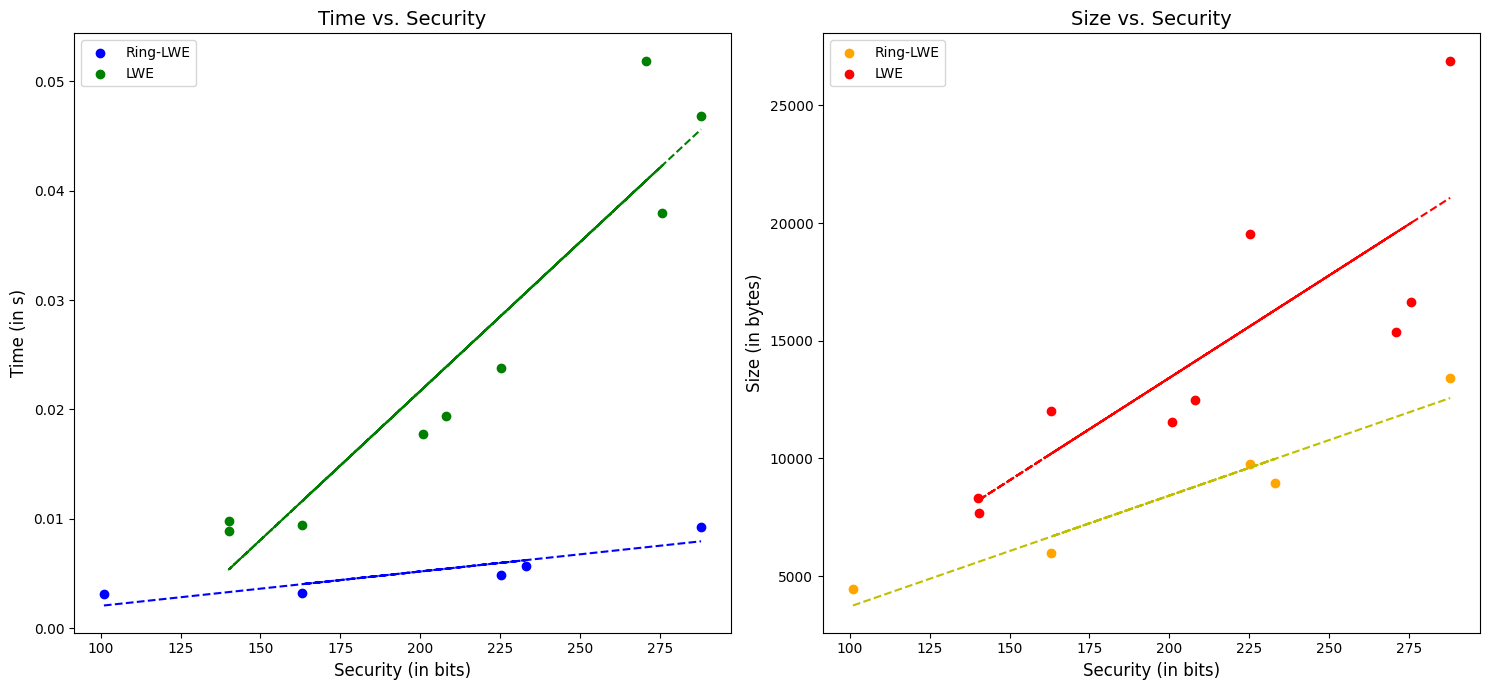

In [29]:
# Generate the trend lines based on the provided data points.
z = np.polyfit(df['Security(in bits)'], df['Time(in s)'], 1)
p = np.poly1d(z)
z2 = np.polyfit(df2['Security(in bits)'], df2['Time(in s)'], 1)
p2 = np.poly1d(z2)


# Re-plotting the graph with adjusted annotations to avoid overlap.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Scatter plots
axes[0].scatter(df['Security(in bits)'], df['Time(in s)'], color='blue', label='Ring-LWE')
axes[0].scatter(df2['Security(in bits)'], df2['Time(in s)'], color='green', label='LWE')
axes[1].scatter(df['Security(in bits)'], df['Size(in bytes)'], color='orange', label='Ring-LWE')
axes[1].scatter(df2['Security(in bits)'], df2['Size(in bytes)'], color='red', label='LWE')

# Trend lines
axes[0].plot(df['Security(in bits)'], p(df['Security(in bits)']), "b--")
axes[0].plot(df2['Security(in bits)'], p2(df2['Security(in bits)']), "g--")
z3 = np.polyfit(df['Security(in bits)'], df['Size(in bytes)'], 1)
p3 = np.poly1d(z3)
axes[1].plot(df['Security(in bits)'], p3(df['Security(in bits)']), "y--")
z4 = np.polyfit(df2['Security(in bits)'], df2['Size(in bytes)'], 1)
p4 = np.poly1d(z4)
axes[1].plot(df2['Security(in bits)'], p4(df2['Security(in bits)']), "r--")

# Titles, labels, and legends.
axes[0].set_title('Time vs. Security', fontsize=14)
axes[0].set_xlabel('Security (in bits)', fontsize=12)
axes[0].set_ylabel('Time (in s)', fontsize=12)
axes[0].legend()
axes[1].set_title('Size vs. Security', fontsize=14)
axes[1].set_xlabel('Security (in bits)', fontsize=12)
axes[1].set_ylabel('Size (in bytes)', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()
